# Linear Regression Implementation from Scratch

We are going to implement all parts of linear regression: the data pipeline, the model, the loss function, and the gradient descent optimizer, from scratch. We will only rely on Pytorch's ``tensor`` and ``autograd`` packages.

In [2]:
# import packages
import torch
import random
import matplotlib.pyplot as plt

## Getting Data Sets

We will construct a simple artificial data set where the number of features are set to be 2 and the number of examples to 1000. $X \in \mathbb{R}^{1000 \times 2}$. We will synthesize our data by sampling each point $\mathbf{x}_i$ from a Gaussian distribution. Moreover, we will assume that the linearity assumption holds with true underlying parameters $\mathbf{w} = [2, 3.4]^{\top}$ and $b = 4.2$. Thus our synthetic labels will be given according to the following linear model which includes a noise term $\epsilon$ to account for measurement errors on the features and labels: $$\mathbf{y} = \mathbf{X} \mathbf{w} + b + \epsilon$$.

In [4]:
# code that generates our synthetic data set
def synthetic_data(w, b, num_examples):
    # insert your code here
    X = torch.randn(size=(num_examples, len(w)))
    y = torch.matmul(X, w) + b + (0.01**0.5)*torch.randn(
        size=(num_examples,))
    return X, y

true_w = torch.tensor([2, 3.4])
true_b = 4.2
num_examples = 1000

features, labels = synthetic_data(true_w, true_b, num_examples)

By generating a scatter plot using one of the features and labels, we can clearly observe the linear relationship between the two.

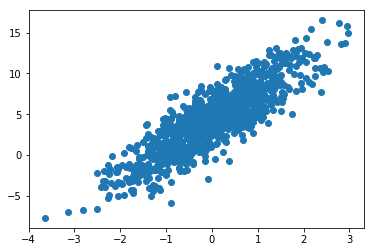

In [5]:
plt.scatter(features[:, 1].numpy(), labels.numpy())

Recall that training models, consists of making multiple passes over the dataset, grabbing one mini-batch of examples at a time and using them to update our model. Since this process is so fundamental to training machine learning algorithms, we need a utility for shuffling the data and accessing in mini-batches.

In [6]:
batch_size = 64
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size, num_examples)])
        minibatch_features = features.index_select(0, batch_indices)
        minibatch_labels = labels.index_select(0, batch_indices)
        yield minibatch_features, minibatch_labels

In [7]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-0.5185,  0.3929],
        [-0.3376, -0.4940],
        [-0.0976,  0.2164],
        [-0.4302,  0.3194],
        [ 0.3103,  0.3260],
        [-0.2841, -1.3921],
        [-0.5936, -0.6728],
        [-2.3061, -0.8861],
        [ 1.1321,  0.2704],
        [ 0.5350,  0.2078]]) tensor([ 4.4613,  1.8016,  4.7529,  4.4578,  5.9394, -1.1919,  0.7543, -3.3525,
         7.4657,  5.9136])


## Initialize Model Parameters

Before we can begin optimizing our model’s parameters by gradient descent, we need to have some parameters
in the first place. In the following code, we initialize weights by sampling random numbers from a normal
distribution with mean 0 and a standard deviation of 0.01, setting the bias $b$ to 0.

In [9]:
w = (0.01**0.5)*torch.randn(size=(2, 1))
b = torch.zeros((1,))

We use automatic differentiation to compute the gradient. We need to invoke the ``requires_grad`` function.

In [10]:
w.requires_grad = True
b.requires_grad = True

## Define the Model

Here, we define our fancy linear model.

In [11]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

## Define the Loss Function

Here, we will use the squared loss function.

In [12]:
def squared_loss(y_hat, y):
    return torch.mean(0.5*(y_hat-y.reshape(y_hat.shape))**2)

## Define the Optimization Algorithm

Here, we introduce your first working examples of stochastic gradient descent (SGD).

In [13]:
def sgd(params, lr):
    # insert your code here
    for param in params:
        param.data = param.data - lr*param.grad.data
        param.grad.data.zero_()

## Training

Now that we have all of the parts in place, we are ready to implement the main training loop. It is crucial
that you understand this code because you will see training loops that are nearly identical to this one over
and over again throughout your career in deep learning.

In [16]:
lr = 0.03 # learning rate
num_epochs = 10 # number of iterations
net = linreg # our linear model
loss = squared_loss # 0.5(y - y')^2

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        y_pred = net(X, w, b)
        l = loss(y_pred, y) 
        l.backward() # compute gradient on l with respect to [w, b]
        sgd([w, b], lr)
    overalldata_pred = net(features, w, b)
    train_l = loss(overalldata_pred, labels)
    print('epoch %d, loss %f' % (epoch, float(train_l)))

epoch 0, loss 0.035378
epoch 1, loss 0.004589
epoch 2, loss 0.004525
epoch 3, loss 0.004514
epoch 4, loss 0.004519
epoch 5, loss 0.004521
epoch 6, loss 0.004545
epoch 7, loss 0.004519
epoch 8, loss 0.004535
epoch 9, loss 0.004520


In [17]:
print('Error in estimating w', true_w - w.reshape(true_w.shape))
print('Error in estimating b', true_b - b)

Error in estimating w tensor([-0.0008, -0.0051], grad_fn=<SubBackward0>)
Error in estimating b tensor([0.0029], grad_fn=<RsubBackward1>)


In [18]:
print(w, true_w)

tensor([[2.0008],
        [3.4051]], requires_grad=True) tensor([2.0000, 3.4000])


Let's plot predicted values versus the true values.

Text(0, 0.5, 'Predicted values')

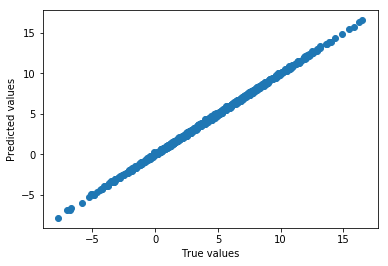

In [19]:
y_pred = net(features, w, b)
plt.scatter(labels.detach().numpy(),
           y_pred.detach().numpy())
plt.xlabel('True values')
plt.ylabel('Predicted values')

Now, let's compute the analytic solution for $\mathbf{w}$:

In [20]:
w_analytic = torch.matmul(torch.matmul(torch.inverse(torch.matmul(features.transpose(0, 1), features)), 
                                features.transpose(0, 1)),
                   labels)

In [21]:
print('Analytic solution for w is', w_analytic)

Analytic solution for w is tensor([2.1659, 3.4494])
